## Final Exam
จากภาพ(ไฟล์แนบ “Template-1.png”) จงเขียนโปรแกรมเพื่อตรวจจับและหาตําแหน่งของวัตถุดังกล่าวในคลิปวิดีโอที่
แนบไปอย่างต่อเนื่อง 
โดยระบบต้องแสดงผลลัพธ์เป็นกรอบของวัตถุในภาพและข้อมูลตําแหน่งของวัตถุในพิกัดฉาก X Y และ Z ใน
หน่วยเมตร เกณฑ์การให้คะแนนมีดังต่อไปนี้
1. ค้นหาวัตถุภายในภาพได้ถูกต้อง ในบางเฟรมของคลิปวิดีโอ 10 คะแนน
2. ค้นหาวัตถุภายในภาพได้ถูกต้อง ในทุกเฟรมของคลิปวิดีโอ 10 คะแนน
3. ระบุตําแหนjงของวัตถุที่ตรวจจับได้เป็นในระบบพิกัดฉาก (X,Y,Z) 10 คะแนน

In [1]:
!pip install  opencv-contrib-python==4.5.3.56
import numpy as np 
import cv2 
import matplotlib.pylab as plt
from skimage import io

<h1 style="text-align: center;">
    Feature Object Detection
</h1>


In [2]:
def preprocessing(img) :  #จาก Homework9p2 เป็นการนำภาพ img มาทำเป็น Gray จากนั้น ส่งภาพ Img,img_gray กลับไปยังต้นฉบับ
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #ทำการเปลี่ยนสีของภาพในเเต่ละเฟรมจาก BGR เป็น Gray เก็บไว้ใน Img_gray
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return (img, img_gray)  #ส่งภาพที่ทำเป็น Gray เเละภาพต้นฉบับออกไป

In [3]:
sift = cv2.SIFT_create()    #ใช้หา Keypoints หรือ จุดเด่นของภาพ
bf = cv2.BFMatcher()        #เป็นการจับคู่ลักษณะของภาพที่เหมือนกัน

In [4]:
#feature_object_detection จาก Homework9p2 ตรวจจับความเหมือนของภาพเเละสร้างกรอบบนภาพ
def feature_object_detection(template_img, template_gray, query_img, query_gray, min_match_number) : 
    template_kpts, template_desc = sift.detectAndCompute(template_gray, None)
    query_kpts, query_desc = sift.detectAndCompute(query_gray, None)
    matches = bf.knnMatch(template_desc, query_desc, k=2)
    good_matches = list()
    good_matches_list = list()
    for m, n in matches :
        if m.distance <= 0.7*n.distance :
            good_matches.append(m)
            good_matches_list.append([m])
    
    if len(good_matches) > min_match_number :
        src_pts = np.float32([ template_kpts[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
        dst_pts = np.float32([ query_kpts[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)

        H, inlier_masks = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 2) # H RANSAC 
        
        # get the bounding box around template image
        h, w = template_img.shape[:2]
        template_box = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1,1,2)
        transformed_box = cv2.perspectiveTransform(template_box, H)

        detected_img = cv2.polylines(query_img, [np.int32(transformed_box)], True, (0,0,255), 5, cv2.LINE_AA)
        drawmatch_img = cv2.drawMatchesKnn(template_img, template_kpts, detected_img, query_kpts, good_matches_list, None, flags=2, matchesMask=inlier_masks)

        return detected_img, drawmatch_img
    else :
        print('Keypoints not enough')
        return
    

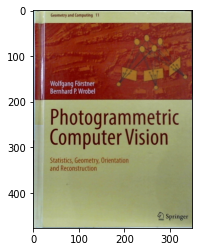

In [5]:
template_img_src = "./images/final_exam/Templates/Template-1.png"  #ภาพต้นฉบับของหนังสือ
template_img = io.imread(template_img_src)                         #
template_img, template_gray = preprocessing(template_img)          #
plt.imshow(template_img)                                           #ทำการแสดงภาพ Template_img ด้วย matplotlib

<h1 style="text-align: center;">
    Detected Video Show time
</h1>

In [6]:
video_src = cv2.VideoCapture('./videos/final_exam/Dataset-1/left_output-1.avi')  #เรียกใช้งานวิดีโอ left_output-1 ในโฟลเดอร์ 
video_src.set(cv2.CAP_PROP_FRAME_WIDTH, 864)  #ความกว้างของเฟรมในสตรีมวิดีโอ
video_src.set(cv2.CAP_PROP_FRAME_HEIGHT, 480) #ความสูงของเฟรมในสตรีมวิดีโอ

while video_src.isOpened() :                    #เงื่อนไขให้วิดีโอ isOpened() หรือเล่นต่อไปเรื่อย ๆ
    ret, frame = video_src.read()               #ทำการอ่านค่าวิดีโอจาก video_src ออกมาเป็น ret และ frame
    
    if ret :                                    #ทำการตรวจสอบเงื่อนไขภาพที่อ่าน ถ้า ret มีค่าเป็นจริงให้ทำขั้นตอนต่อไป
        video_gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)      #ทำการเปลี่ยนสีของภาพในเเต่ละเฟรมจาก BGR เป็น Gray
        detected, drawmatch =  feature_object_detection(template_img, template_gray, frame, video_gray, 2)      #ทำการเรียกใช้ feature_object_detection ในการทำ detected, drawmatch
                                                                                                                
        cv2.imshow('Video Detected', frame)      #ทำการแสดงภาพของเเต่ละ Frame ในหน้าต่าง "video Detection"
        if cv2.waitKey(int(1000/30)) & 0xFF == ord('q') : # this line control the period between image frame 
            break                               #ทำการออกจากเงื่อนไข
    else :                                      #ถ้า ret มีค่าเป็นเท็จ
        break                                   #ทำการออกจากเงื่อนไข
video_src.release()                             #คืนค่าตัวแปรทั้งหมด
cv2.destroyAllWindows()                         #ปิดหน้าจอการทำงานทั้งหมด